# Notes

In this example, we aim to delve into the features learned through our pretraining process, with a focus on identifying the most significant types of features. Our exploration will first cover cell-level features, followed by an analysis of geneset-level features.

In [1]:
import sys
sys.path.insert(0, '/home/was966/Research/mims-responder/')
from responder.utils import plot_embed_with_label, score
from responder import PreTrainer, FineTuner, loadresponder

In [2]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)

def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan]].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

In [7]:
# load the pretrained model as a feature extractor
pretrainer = loadresponder('./results/Pretrain_ssl_notask_20240111_174630/pretrainer.pt')
genesetprojector = pretrainer.model.latentprojector.genesetprojector
cellpathwayprojector = pretrainer.model.latentprojector.cellpathwayprojector
pretrainer.count_parameters()

79696

In [4]:
data_path = '../data/'
from responder.utils import plot_embed_with_label, score
skcm_df_label = pd.read_pickle(os.path.join(data_path, 'SKCM','PATIENT.ITRP.TABLE'))
skcm_df_tpm = pd.read_pickle(os.path.join(data_path, 'SKCM','TPM.ITRP.TABLE'))
skcm_df_task = onehot(skcm_df_label.response_label)

In [6]:
celltype_features, y_random = pretrainer.predict(skcm_df_tpm,  batch_size= 128)

100%|##########| 3/3 [00:01<00:00,  1.92it/s]


In [12]:
celltype_feature_names = cellpathwayprojector.cellpathway_names
celltype_features.columns = celltype_feature_names
label = skcm_df_label['response_label']
cohort = skcm_df_label['cohort']

dfp = celltype_features.join(label).join(cohort)

In [13]:
dfp.head(3)

,Adipocyte,Bcell,CPI_Response,Cholangiocyte,Cytokine,Endothelial,Epithelial,Erythrocyte,Fibroblast,Granulocyte,...,Platelet,Pneumocyte,Reference,Stem,Stroma,TLS,Tcell,cDC,response_label,cohort
Patient100_T_P,-0.006031,-0.011188,-0.009422,-0.011098,-0.005434,-0.029600,-0.013924,0.009660,-0.016189,-0.004235,...,0.033606,-0.016173,-0.002073,0.000180,-0.001709,-0.007604,-0.000525,-0.003923,R,Liu
Patient102_T_P,-0.005933,-0.004892,-0.001054,-0.009836,-0.000205,-0.010659,-0.032794,-0.003216,-0.013400,-0.002890,...,0.049131,-0.017349,-0.001337,0.004383,-0.001217,-0.004156,-0.000200,-0.002035,R,Liu
Patient105_T_P,-0.003995,-0.001886,-0.004350,-0.009320,-0.001992,-0.003490,-0.028898,0.005271,-0.001782,-0.001422,...,0.045936,0.001430,-0.000705,0.009605,-0.000346,-0.002089,0.000111,-0.000467,R,Liu


Text(233.25, 0.5, 'Cohort')

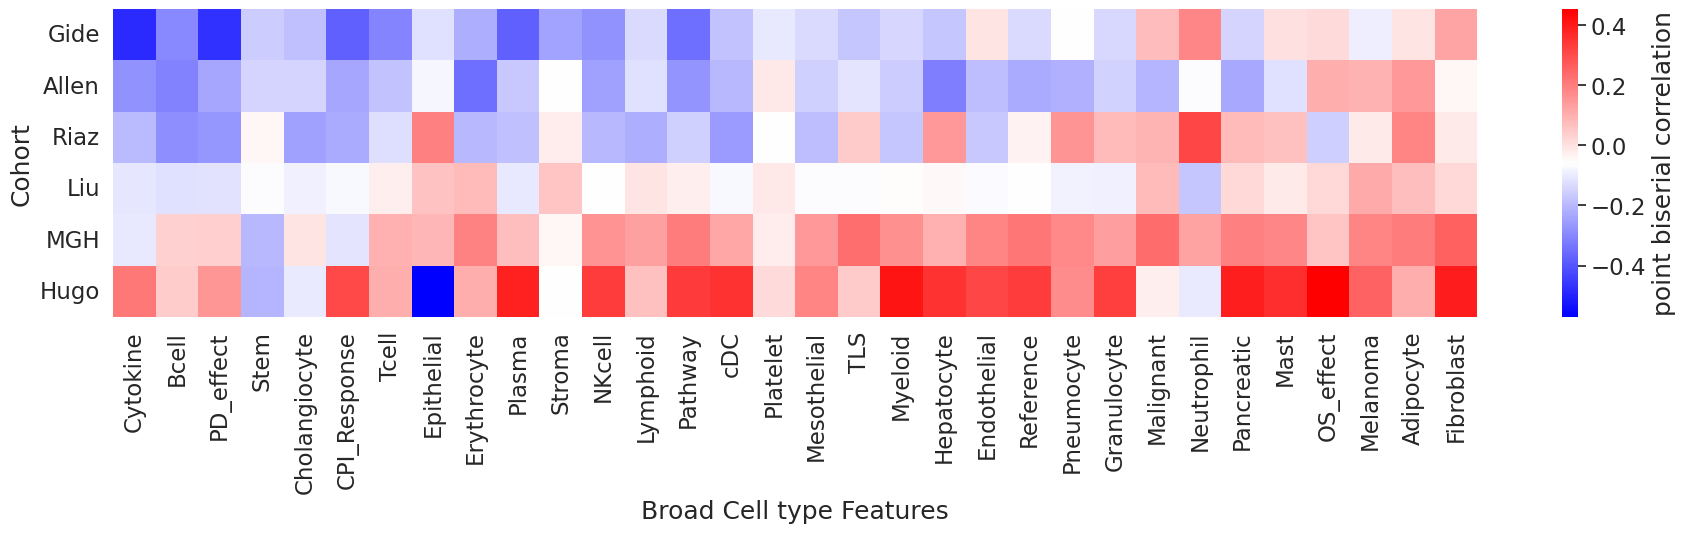

In [15]:
import scipy.stats as stats

res= []
for f in feat_names:
    p = dfp.groupby('cohort').apply(lambda x:stats.pointbiserialr(x.response_label.map({'R':1, 'NR':0}), x[f])[0])
    p = p.to_frame(f)
    res.append(p)
    
pcc = pd.concat(res, axis=1)
pcc = pcc[pcc.mean().sort_values().index]
pcc = pcc.loc[pcc.mean(axis=1).sort_values().index]

fig, ax = plt.subplots(figsize = (22,4))
sns.heatmap(pcc, cmap = 'bwr', ax=ax, cbar_kws={'label': 'point biserial correlation'})
ax.set_xlabel('Broad Cell type Features')
ax.set_ylabel('Cohort')

Text(233.25, 0.5, 'Cohort')

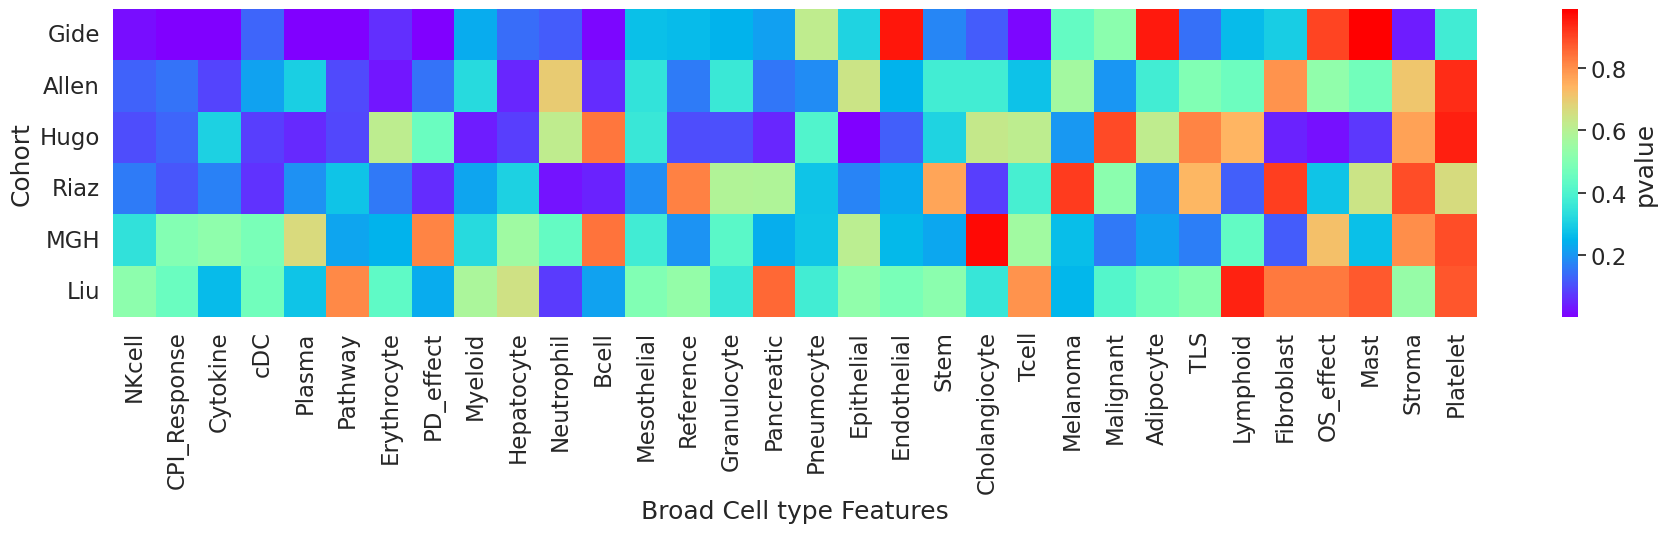

In [16]:
res = []
for f in feat_names:
    p = dfp.groupby('cohort').apply(lambda x:stats.pointbiserialr(x.response_label.map({'R':1, 'NR':0}), x[f])[1])
    p = p.to_frame(f)
    res.append(p)

pcc = pd.concat(res, axis=1)
pcc = pcc[pcc.mean().sort_values().index]
pcc = pcc.loc[pcc.mean(axis=1).sort_values().index]
# pcc = 1.5**pcc
fig, ax = plt.subplots(figsize = (22,4))
sns.heatmap(pcc, cmap = 'rainbow', ax=ax, cbar_kws={'label': 'pvalue'})

ax.set_xlabel('Broad Cell type Features')
ax.set_ylabel('Cohort')

/tmp/ipykernel_134163/4027021859.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize = (10,4))


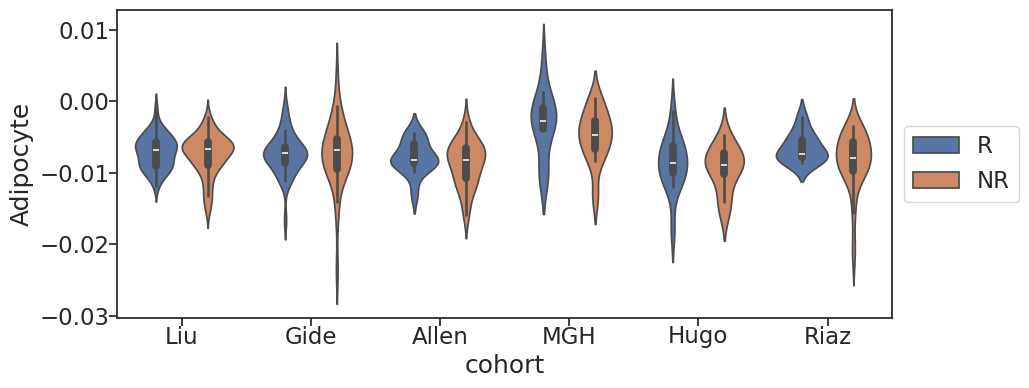

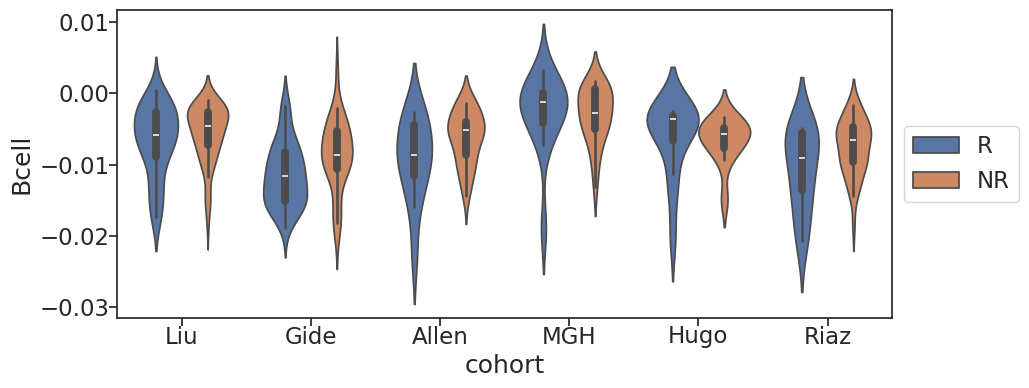

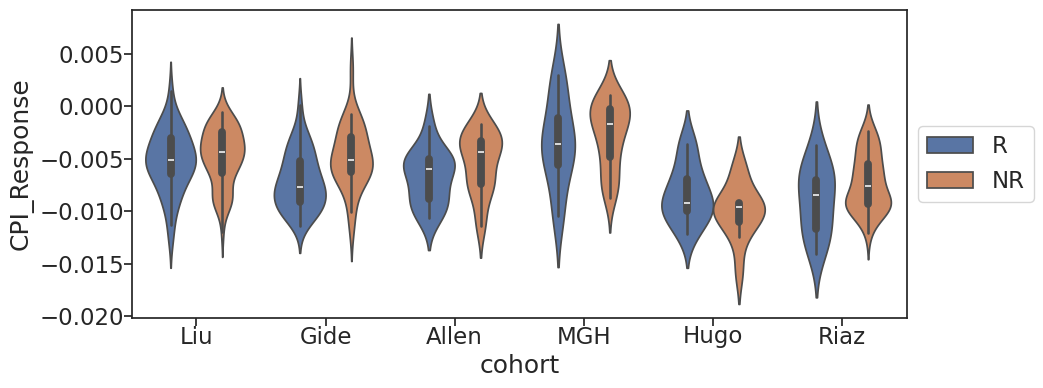

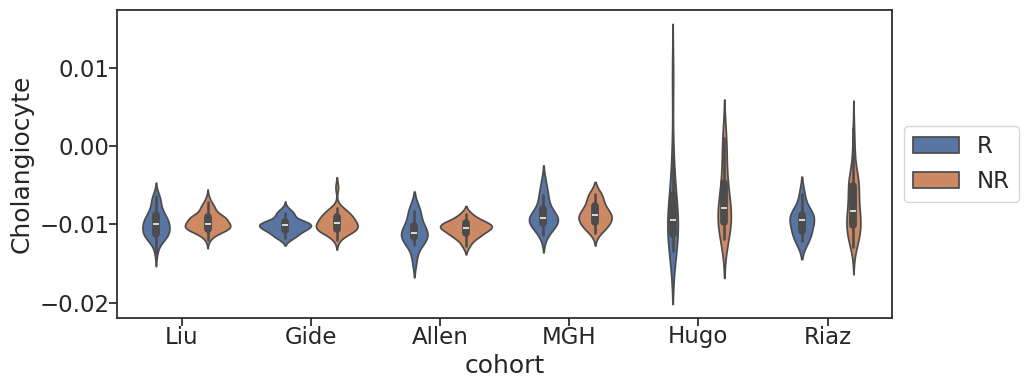

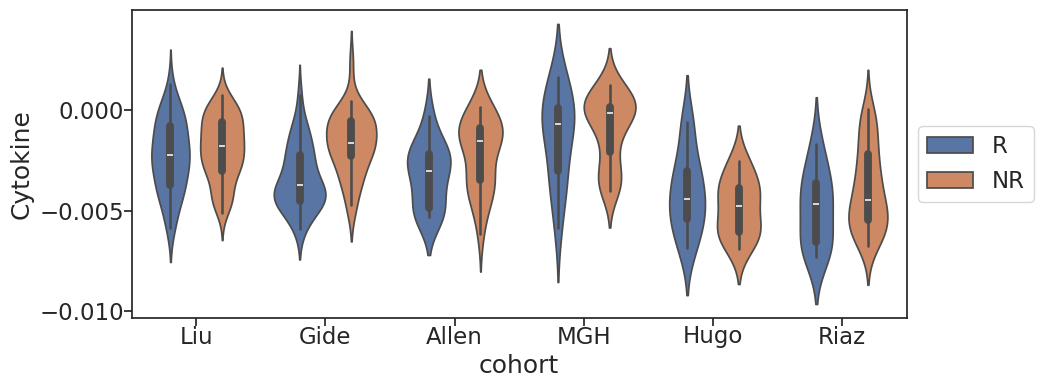

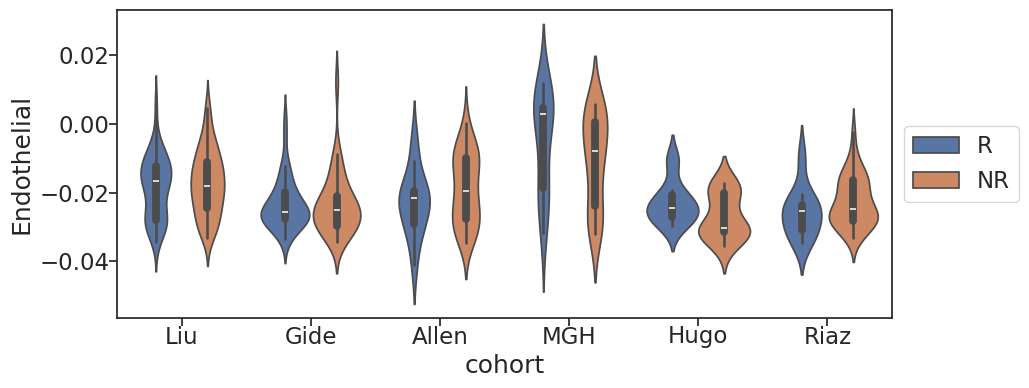

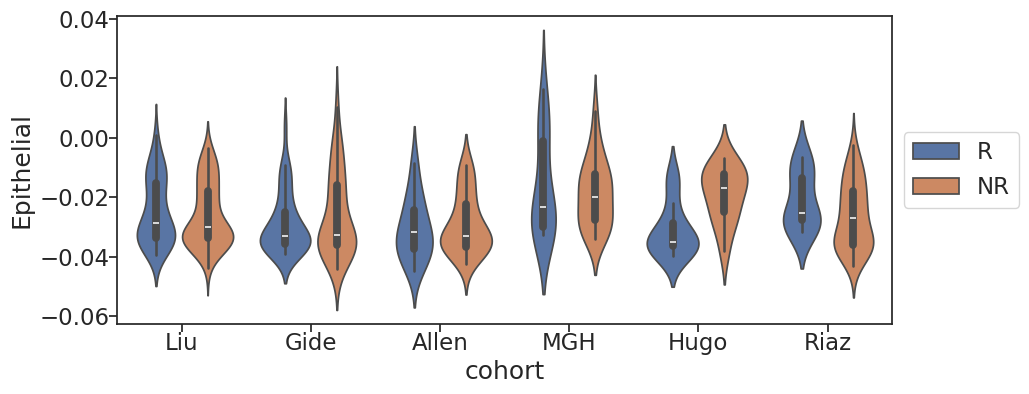

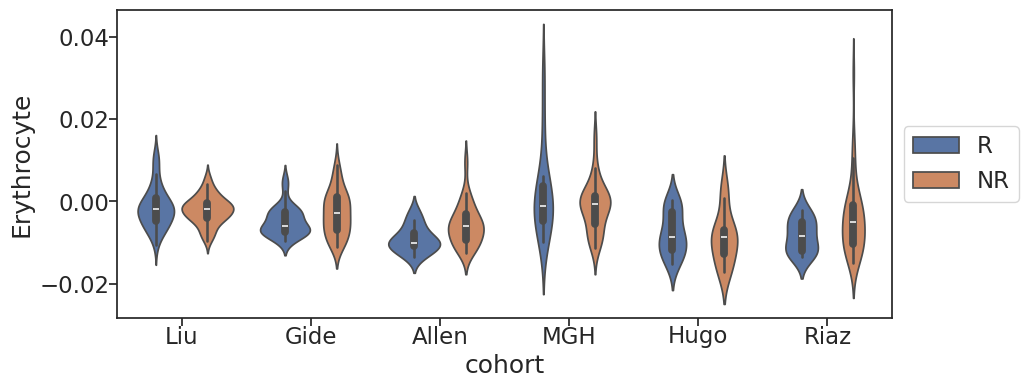

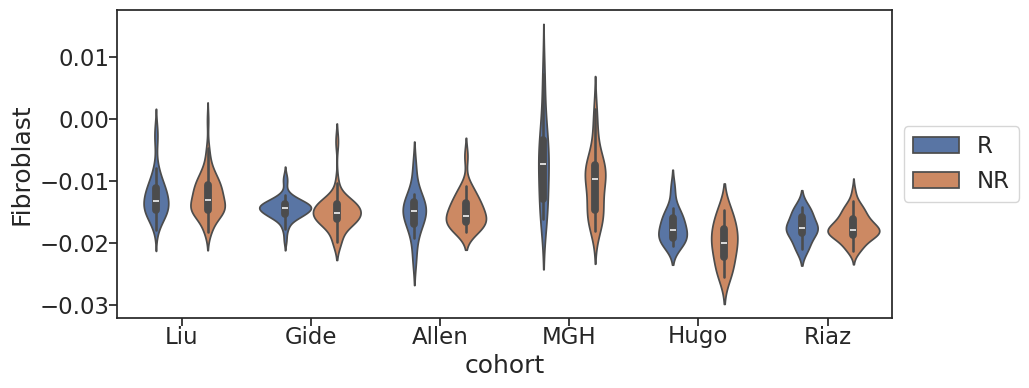

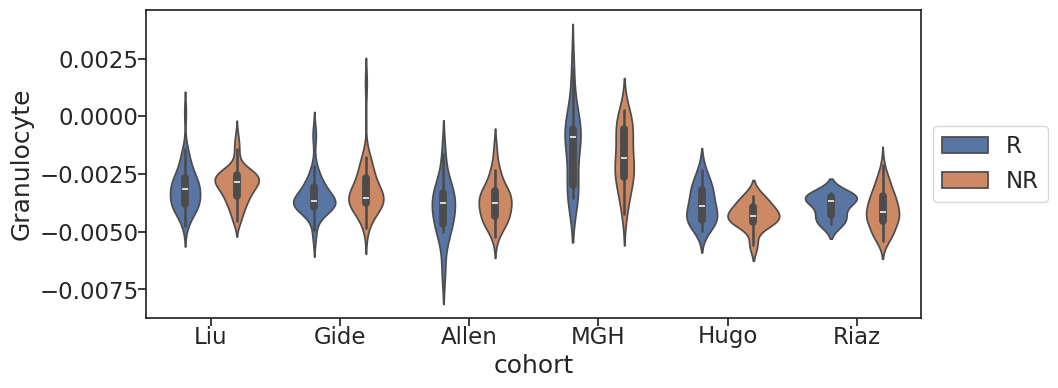

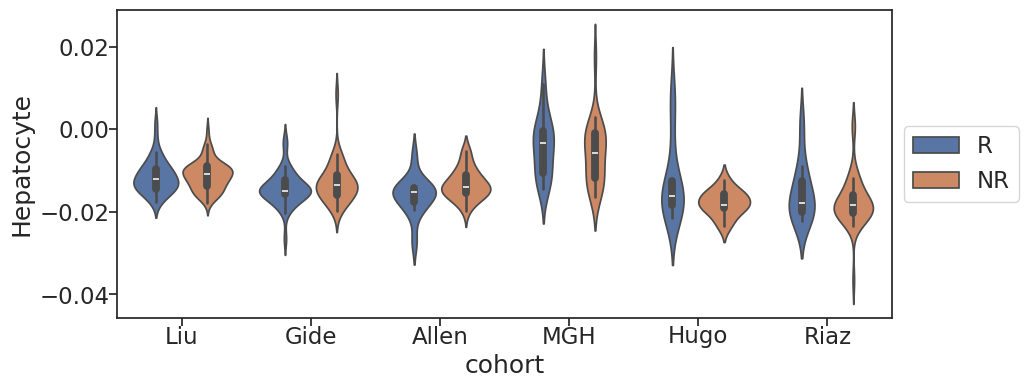

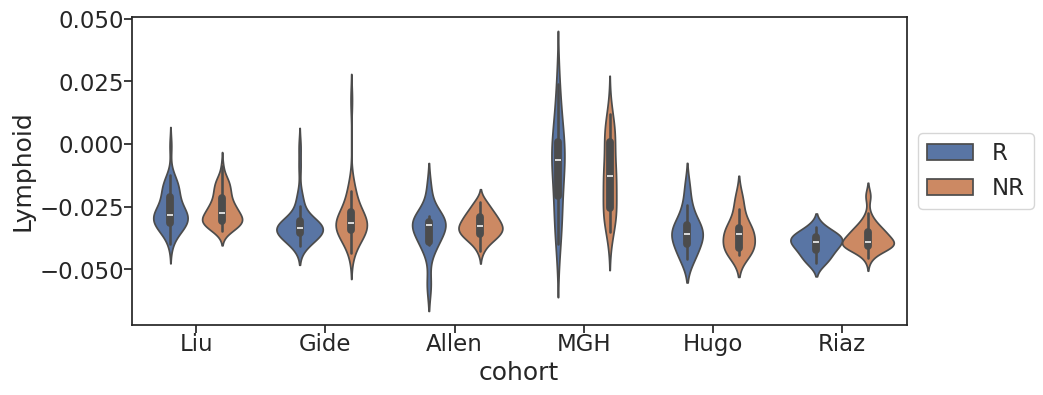

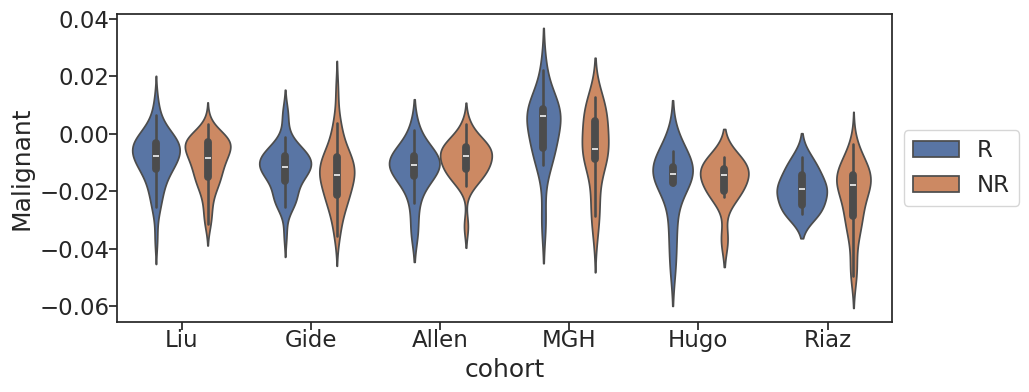

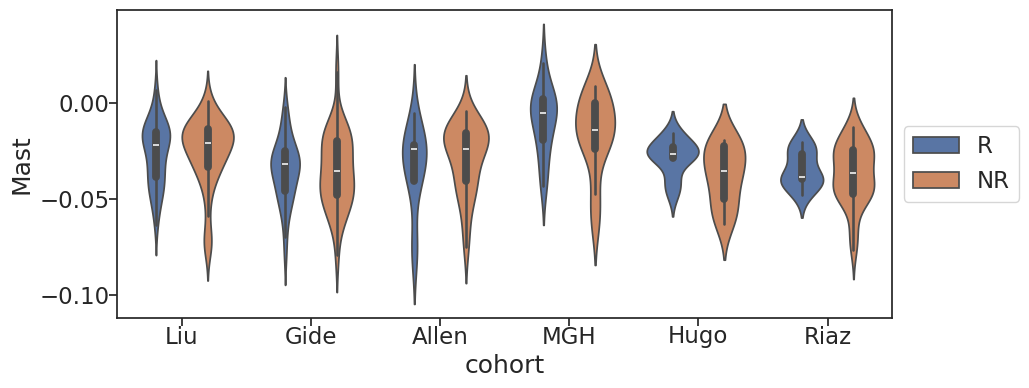

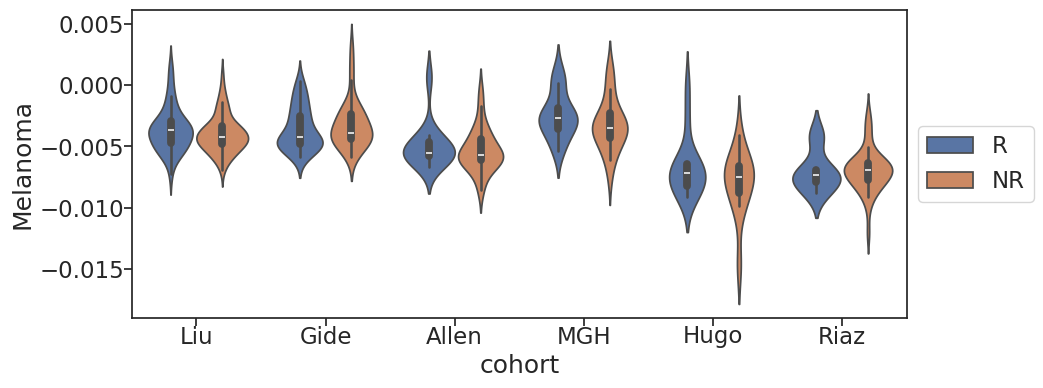

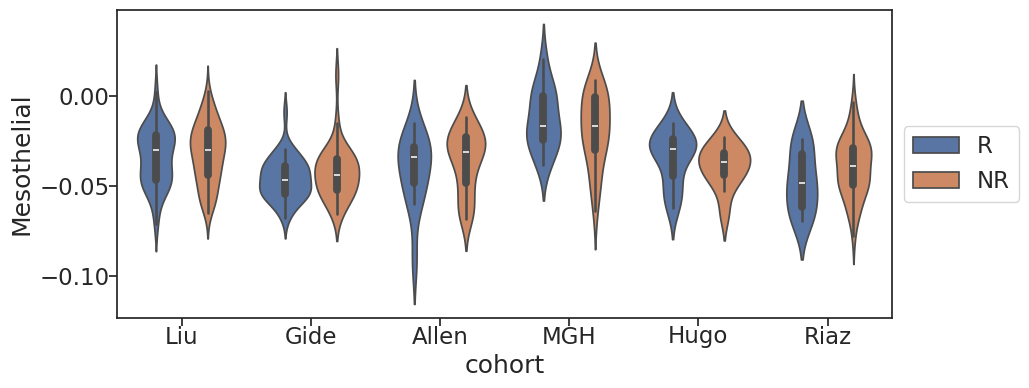

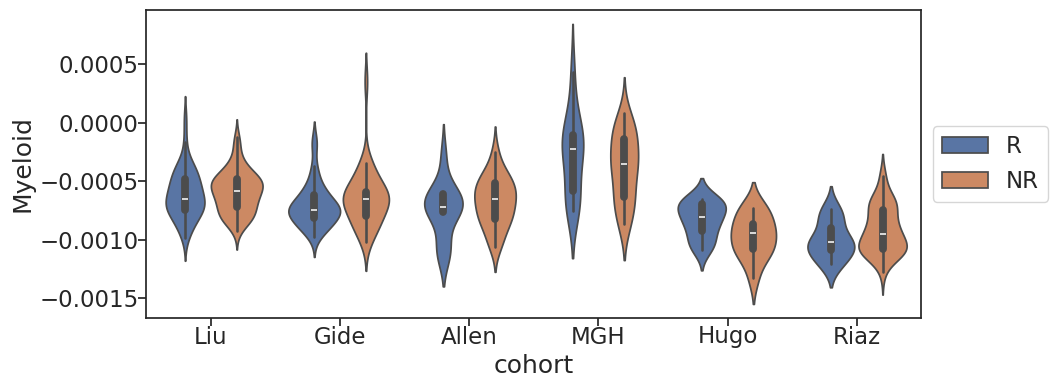

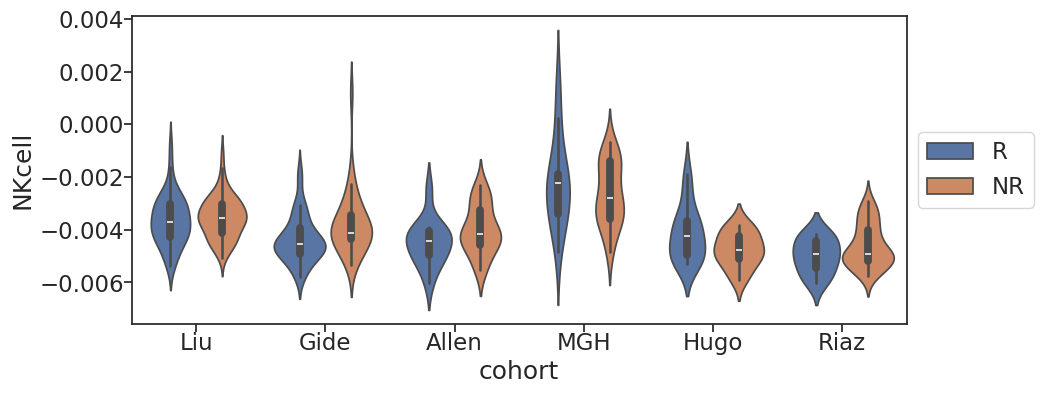

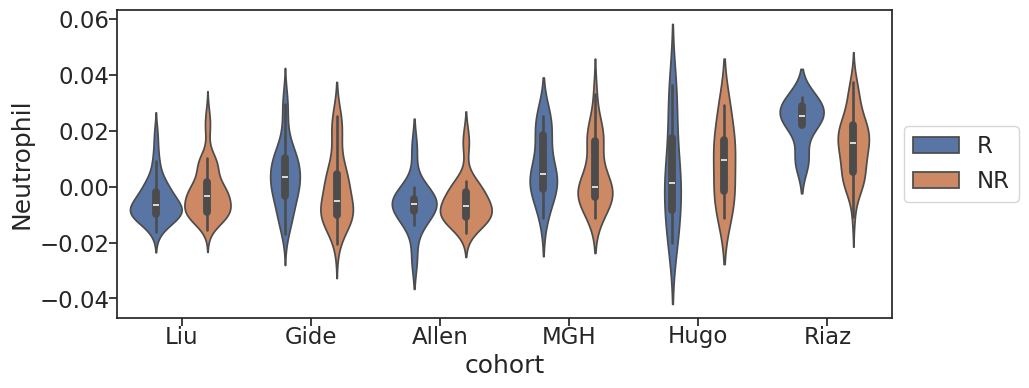

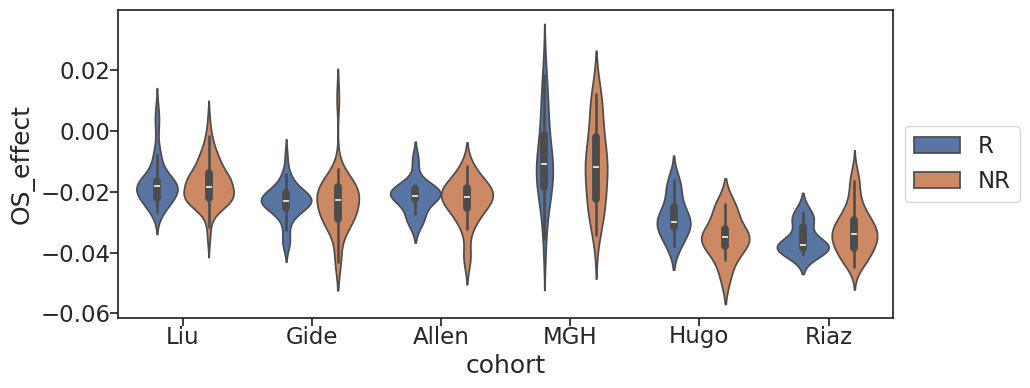

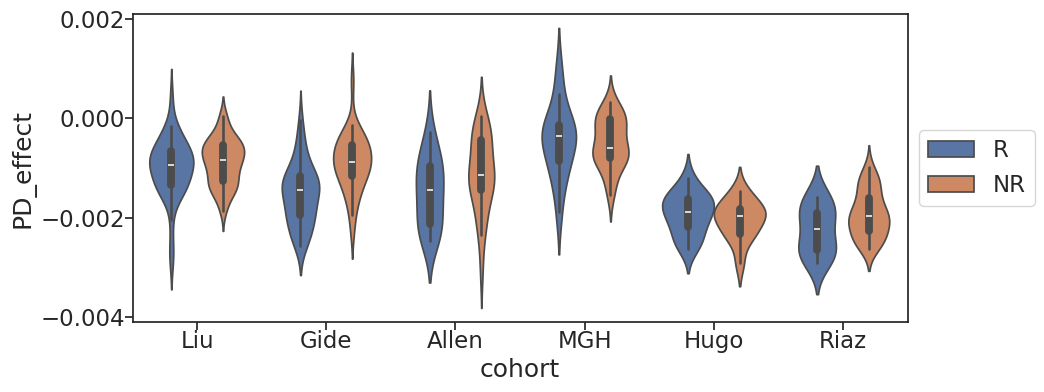

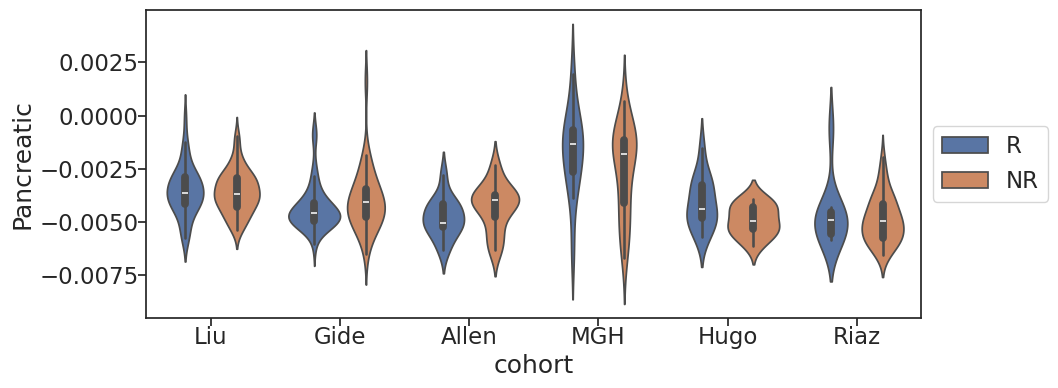

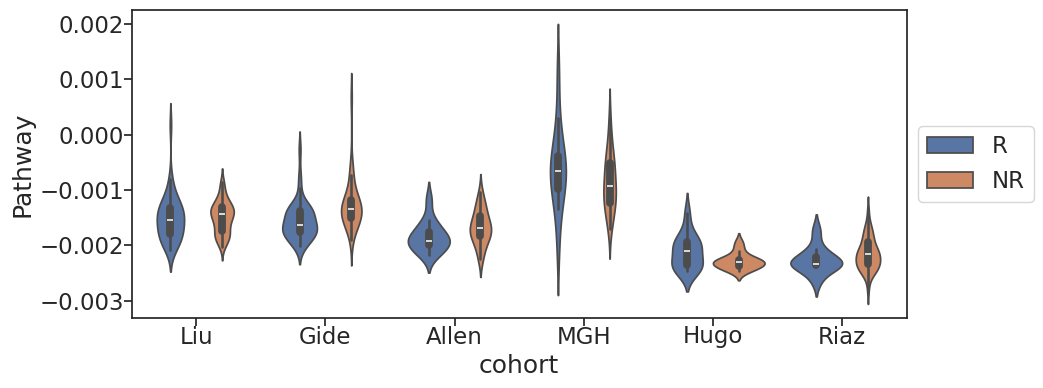

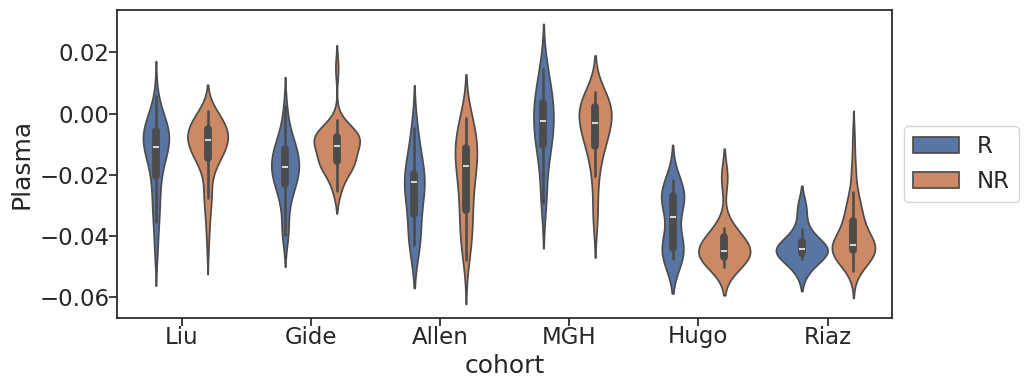

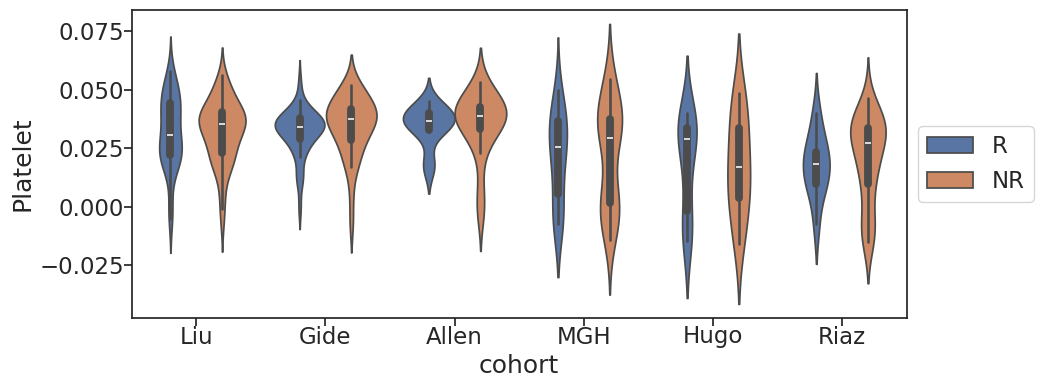

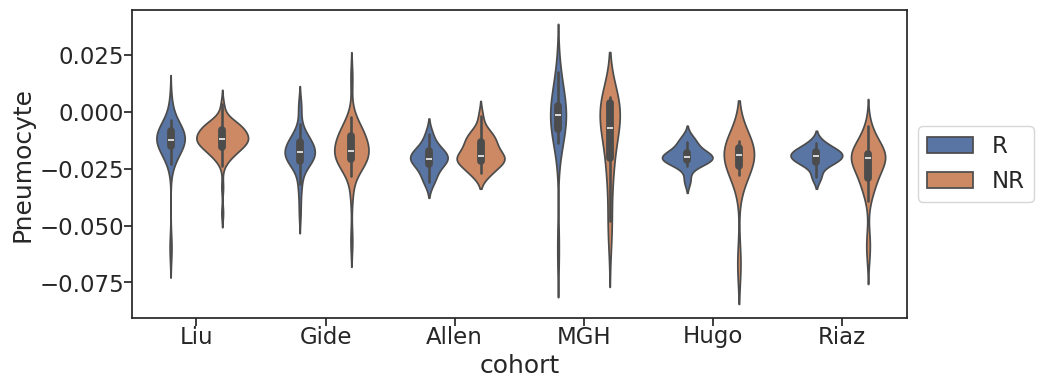

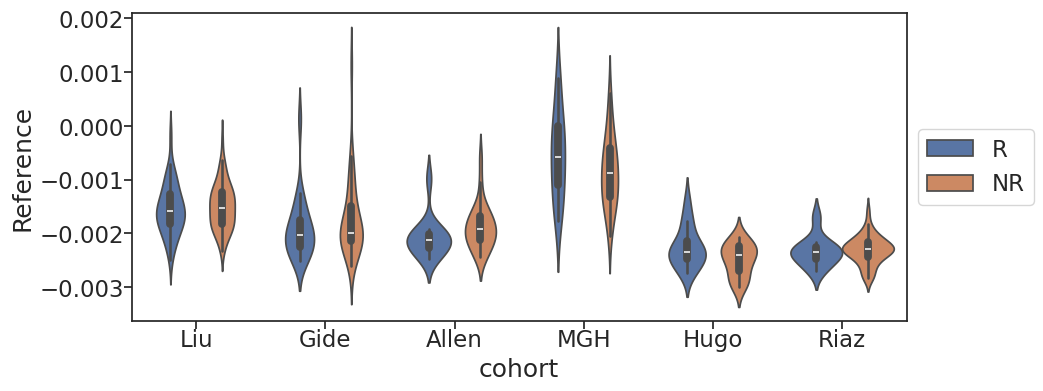

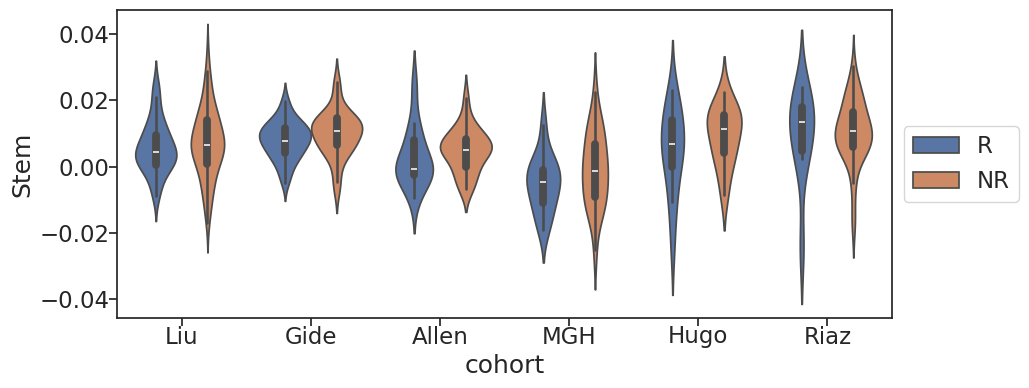

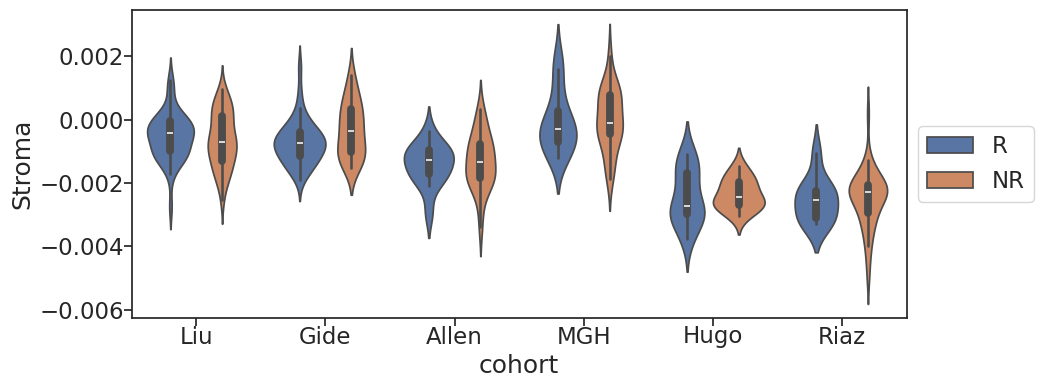

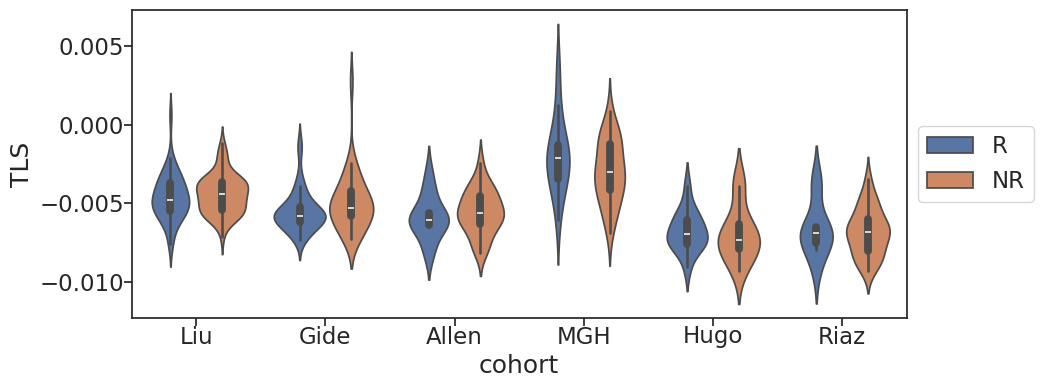

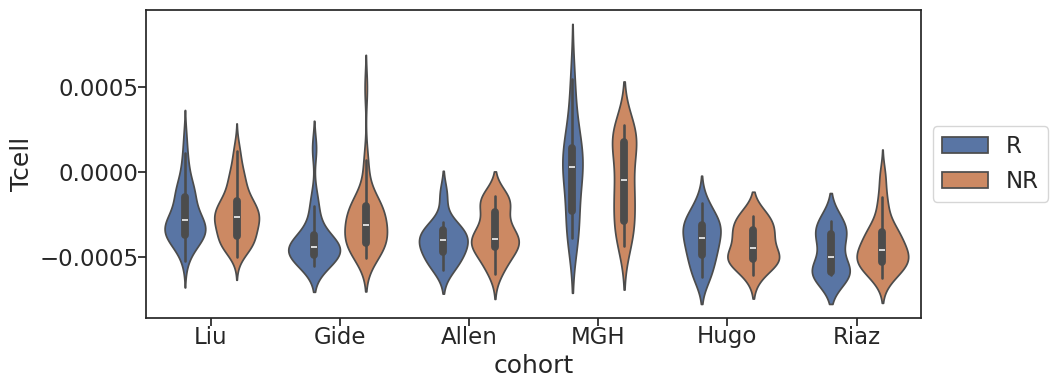

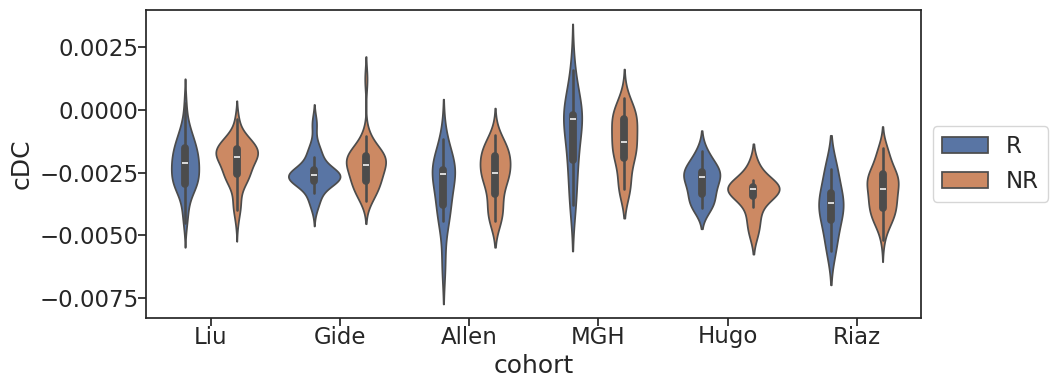

In [18]:
from statannot import add_stat_annotation
for y in feat_names:
    x = 'cohort'
    hue = 'response_label'
    data = dfp

    fig, ax = plt.subplots(figsize = (10,4))
    sns.violinplot(data = data, x=x, y=y, hue=hue, ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
    
    # add_stat_annotation(ax, data=data, x=x, y=y, hue=hue,
    #                     box_pairs=[("R", "NR")],
    #                     test='Mann-Whitney', text_format='star', loc='outside', verbose=2)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 [Text(0, 0, 'ResourceCD8Tcell_sc'),
  Text(1, 0, 'Target_marker_CTLA4'),
  Text(2, 0, 'CD4Tcell_Combes22'),
  Text(3, 0, 'Tcell_l_Danaher17'),
  Text(4, 0, 'GoodCD8Tcell_l_SadeFeldman18'),
  Text(5, 0, 'CD8Tcell_Combes22'),
  Text(6, 0, 'ExhCD8Tcell_l_Danaher17'),
  Text(7, 0, 'RegTcell_Blood_l_Zhang18'),
  Text(8, 0, 'Target_marker_PD1'),
  Text(9, 0, 'Jiang_Texh'),
  Text(10, 0, 'CD8Tcell_sc'),
  Text(11, 0, 'CMCD4Tcell_sc'),
  Text(12, 0, 'Tcell_IL7Rmax_sc'),
  Text(13, 0, 'BadCD8Tcell_l_SadeFeldman18'),
  Text(14, 0, 'Target_marker'),
  Text(15, 0, 'IMPRES_set1'),
  Text(16, 0, 'TCMGS'),
  Text(17, 0, 'NaiTcell_sc'),
  Text(18, 0, 'RegTcell_Combes22'),
  Text(19, 0, 'RegTcell_l_Li19'),
  Text(20, 0, 'CytoxTcell_l_Li19'),
  Text(21, 0, 'Tcell_Combes22'),
  Text(22, 0, 'Davoli_CIS'),
  Te

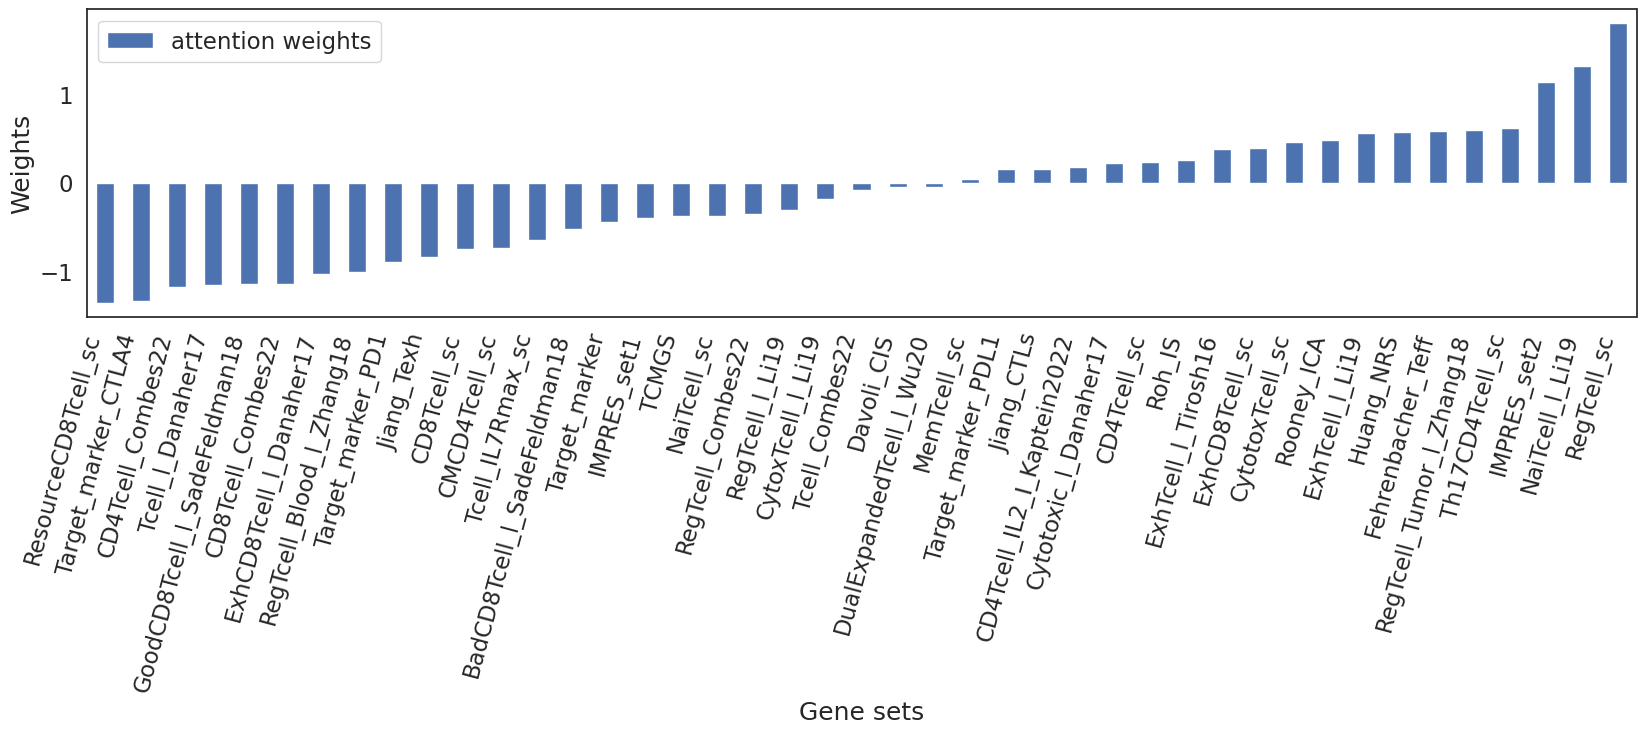

In [27]:
w = cellpathwayprojector.cellpathway_aggregator.aggregator.attention_weights['cellpathway_30']
idx = genesetprojector.GENESET.iloc[cellpathwayprojector.CELLPATHWAY.loc['Tcell']].index.to_list()
Tcell_weights = pd.DataFrame(w.cpu().detach().numpy(),columns = ['attention weights'], index=idx)
fig, ax = plt.subplots(figsize = (20,4))

Tcell_weights.sort_values('attention weights').plot(kind='bar',ax=ax)
ax.set_ylabel('Weights')
ax.set_xlabel('Gene sets')
plt.xticks(rotation=75, ha='right')